## 이론 정리

### bAbI 프로젝트
2015년 페이스북 AI 연구소에서 시작한 bAbI 프로젝트. __모델의 언어 이해 및 추론 능력을 테스트__ 하는 이 프로젝트는 총 20개의 태스크가 있으며 10,000개의 훈련 데이터 쌍 / 1,000개의 테스트 데이터 쌍으로 구성된다.

- [bAbI 프로젝트 공식 홈페이지](https://research.fb.com/downloads/babi/)

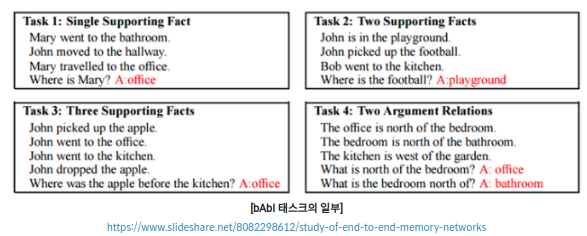

"스토리"(문장들의 모음)을 들려주고 질문을 던지면 인공지능이 스토리로부터 정답을 맞춘다.

### bAbI 데이터셋에 대한 이해
- bAbI 프로젝트의 데이터셋의 형식

```python
ID text
ID text
ID text
ID question[tab]answer[tab]supporting_fact ID.
...
```

- ID: 각 문장의 번호, 스토리가 시작될 때 1번으로 시작함. 

``` python
1 Sandra travelled to the kitchen. 
2 Sandra travelled to the hallway. 
3 Mary went to the bathroom. 
4 Sandra moved to the garden. 

5 Where is Sandra?      Garden         4
```
위의 4개의 문장으로 구성된 스토리로부터 질문과 정답이 나온다. 레이블에 해당하는 Garden은 질문 뒤에 tab 하나를 두고 등장한다. Garden 옆의 숫자 4는 __Supporting fact__ 로서 실제 정답이 주어진 스토리에서 몇 번 id의 문장에서 있었는지 알려준다. 실제로 인공지능의 훈련 단계에서는 supporting fact는 학습하지 않는 것이 원칙이다. 

context 문장의 의미를 정확히 해석하지 않아도 문장의 구조와 패턴을 충분히 학습하면 모델이 정답을 맞출 수 있는 SQuAD와 달리 bAbl 데이터셋은 패턴의 유사성만으로는 답을 찾을 수 없고, 'Emily'→'wolf'→'afraid of cat'의 연역적 추론을 거쳐서 답('cat')을 찾을 수 있다. 이는 사용자와 지속적으로 대화의 맥락을 이어나가면서 대화 도중 주고받은 정보를 재활용하여 커뮤니케이션할 수 있는 챗봇에 사용될 수 있다.

- Multi-hop Reasoning 능력    
과거의 정보와 지식을 활용해서 연역적 추론을 통해 새로운 결론에 이를 수 있는 능력을 가지려면 모델이 과거의 정보와 지식을 저장해 두는 저장소인 메모리(memory)가 필요하다. 

###  End-to-end Memory Network
이번 프로젝트에서 구현할 End-to-end Memory Network 모델의 구조는 아래와 같다. 

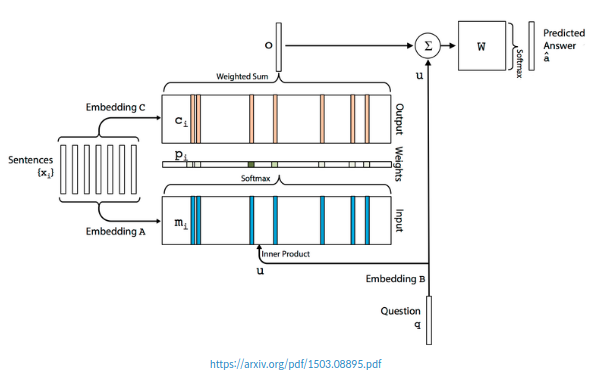

2014년에 발표된 두 논문(NTM, RNNsearch)에서 인사이트를 얻어 2015년 페이스북 AI 리서치의 논문 [End to End Memory Networks](https://arxiv.org/pdf/1503.08895)가 발표되었다. End-to-End Memory Network는 bAbl task의 오류율을 7.5%까지 낮추었고, Memory Network의 가장 기본적인 베이스라인으로 여겨진다. 

## 14-6. 프로젝트: 한국어 QA 모델 만들기
아래의 데이터셋은 bAbI 데이터셋을 저자가 한국어로 변환한 한국어 버전의 bAbI 데이터셋입니다.

### 데이터 다운로드
e-28-korean.zip 

압축을 해제해서 사용해주세요.


- [데이터셋 소개]
데이터셋의 형태는 아래와 같이 영어 데이터셋과 동일합니다.

```python
1 은경이는 복도로 가버렸습니다.
2 필웅이는 화장실로 뛰어갔습니다.
3 은경이는 어디야?     복도  1
4 수종이는 화장실로 복귀했습니다.
5 은경이는 침실로 갔습니다.
6 필웅이는 어디야?     화장실 2
7 은경이는 복도로 이동했습니다.
8 경임이는 부엌으로 뛰어갔습니다.
9 경임이는 어디야?     부엌  8
10 경임이는 복도로 가버렸습니다.
11 은경이는 정원으로 이동했습니다.
12 경임이는 어디야?     복도  10
13 경임이는 화장실로 복귀했습니다.
14 경임이는 부엌으로 갔습니다.
15 경임이는 어디야?     부엌  14
```

이번 프로젝트에서는 위 한국어 버전의 데이터셋에 대해서 동작하는 QA 모델을 만들어보겠습니다.

>주의❗ 기존 케라스 공식 문서의 babi_rnn, babi_memn 구현은 파이썬 3.6을 기준으로 하고 있으며, 파이썬 3.7에서는 정상동작 하지 않을 수 있습니다. 실습 시 참고하세요!

### 데이터 로드

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

In [2]:
import random 
import tensorflow as tf

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
# 환경에 맞게 경로 적절히 수정
home_dir = os.getenv('HOME')+'/aiffel/babi_memory_net'
DATA_DIR = home_dir + '/e-28-korean'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

In [4]:
i = 0
lines = open(TRAIN_FILE , "rb")  # open: opens a file in text format by default. 
# rb:opens the file in binary format for reading 
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


### 데이터 전처리 
데이터를 읽는 과정에서 스토리, 질문, 답변을 각각 분리해서 저장한다. supporting fact(실제 정답이 몇 번째 문장에 있었는지를 알려주는 인덱스 힌트 정보)는 저장하지 않는다.


In [5]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거 (문자열에서 인코딩 'b' 제거)
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리 
        # 위에서 1은 2개의 요소로만 분리하는 것을 의미함. 만약 원소가 4개면 1개 + 3개 이렇게 출력
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:  # id
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장, _는 supporting fact
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [6]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [7]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [8]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [9]:
train_stories[3878]

['수종이는 화장실로 뛰어갔습니다.',
 '경임이는 사무실로 갔습니다.',
 '은경이는 부엌으로 이동했습니다.',
 '경임이는 화장실로 갔습니다.',
 '수종이는 복도로 갔습니다.',
 '필웅이는 부엌으로 가버렸습니다.',
 '수종이는 부엌으로 이동했습니다.',
 '수종이는 화장실로 가버렸습니다.']

In [10]:
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

### Step 1. 토크나이저 변경하기 (매우 중요!!!)
영어권 언어는 띄어쓰기만해도 단어들이 잘 분리되지만, 한국어는 그렇지 않다고 앞에서 몇 차례 언급했었죠? 한국어 데이터를 사용하여 모델을 구현하는 것만큼 이번에는 형태소 분석기를 사용해서 단어 토큰화를 해보겠습니다. 그런데 형태소 분석기를 사용할 때, 이런 상황에 봉착한다면 어떻게 해야할까요?

```python
형태소 분석 입력 : '은경이는 사무실로 갔습니다.'
형태소 분석 결과 : ['은', '경이', '는', '사무실', '로', '갔습니다', '.']
```

사실 위 문장에서 '은경이'는 사람 이름이므로 제대로 된 결과를 얻기 위해서는 '은', '경이'와 같이 글자가 분리되는 것이 아니라 '은경이' 또는 최소한 '은경'이라는 단어 토큰을 얻어야만 합니다. 이런 경우에는 형태소 분석기에 사용자 사전을 추가해줄 수 있습니다. '은경이'는 하나의 단어이기 때문에 분리하지말라고 형태소 분석기에 알려주는 것이죠.

사용자 사전을 추가하는 방법은 형태소 분석기마다 다소 다른데, 생각보다 복잡한 경우도 많습니다. 이번 실습에서는 Customized Konlpy라는 사용자 사전 추가가 매우 쉬운 패키지를 사용합니다.

#### Customized Konlpy 설치 방법
설치 방법과 사용 방법에 대한 자세한 설명은 아래의 링크를 참고하세요!

[Customized Konlpy 사용하기](https://inspiringpeople.github.io/data%20analysis/ckonlpy/)

가령, 트위터라는 형태소 분석기를 사용한다고 하였을 때, '은경이'라는 단어를 사용자 사전에 추가하고 나서 문장을 형태소 분석하려면 어떻게 해야 할까요?

In [11]:
# 예시 코드
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은경이', '는', '사무실', '로', '갔습니다', '.']

#### 주요 전처리
단어장을 생성, 단어에서 정수로, 정수에서 단어로 맵핑하는 딕셔너리(dictionary)를 만든다. 그 과정에서 스토리와 질문의 가장 긴 길이를 구해 패딩에 이용한다.

한 가지 특이한 과정은 전처리를 하면서 __같은 스토리 내의 여러 문장을 하나의 문장으로 통합__ 하는 것이다. 예를 들어 3,879번째 스토리는 8개의 문장으로 구성되어 있으나 전처리 과정에서 8개의 문장을 모두 이어 붙여서 1개의 문장으로 통합한다.

In [12]:
def tokenize(sent):
    return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] # python 3.7의 경우 
    # return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()] # python 3.6의 경우

In [13]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()  # FreqDist(): 문서에 사용된 단어(토큰)의 사용빈도 정보를 담는다.
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수, reduce(): 앞의 원소에서부터 누적적으로 함수에 적용
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)  # np.max: 전체의 최대값 구하기
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [14]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [15]:
# 단어장 출력
print(word2idx)

{'.': 1, '경임이는': 2, '은경이는': 3, '수종이는': 4, '필웅이는': 5, '이동했습니다': 6, '가버렸습니다': 7, '뛰어갔습니다': 8, '복귀했습니다': 9, '갔습니다': 10, '화장실로': 11, '정원으로': 12, '복도로': 13, '어디야': 14, '?': 15, '부엌으로': 16, '사무실로': 17, '침실로': 18, '화장실': 19, '정원': 20, '사무실': 21, '침실': 22, '복도': 23, '부엌': 24}


띄어쓰기 단위(어절 단위)로 했을 때 총 토큰의 수는 24개이다. 11번부터 19번 토큰 사이의 토큰들은 형태소 분석을 했을 때 '화장실', '정원', '사무실', '침실', '복도', '부엌'으로 분리되어야 한다. (이 부분은 불용어 처리에서 해결하도록 한다.)

사람의 이름은 1-4번까지, 4개의 토큰이 존재하며 사람의 이름이 제대로 분리되어야 한다. 따라서 형태소 분석기를 사용해 원하는 결과를 확인한 후, 정상적인 결과가 나오도록 해주어야 한다. 여기서는 '경임이', '수종이' 등 사람의 이름을 사전에 추가해준다. (은경이는 위에서 해 주었으므로 생략한다.) 

In [16]:
print(twitter.morphs('은경이는 화장실로 이동했습니다.'))
print(twitter.morphs('경임이는 정원으로 가버렸습니다.'))
print(twitter.morphs('수종이는 복도로 뛰어갔습니다.'))
print(twitter.morphs('필웅이는 부엌으로 복귀했습니다.'))
print(twitter.morphs('수종이는 사무실로 갔습니다.'))
print(twitter.morphs('은경이는 침실로 갔습니다.'))

['은경이', '는', '화장실', '로', '이동', '했습니다', '.']
['경', '임', '이', '는', '정원', '으로', '가버렸습니다', '.']
['수종', '이', '는', '복도', '로', '뛰어갔습니다', '.']
['필웅이', '는', '부엌', '으로', '복귀', '했습니다', '.']
['수종', '이', '는', '사무실', '로', '갔습니다', '.']
['은경이', '는', '침실', '로', '갔습니다', '.']


In [17]:
twitter.add_dictionary('경임이', 'Noun')
twitter.add_dictionary('수종이', 'Noun')

In [18]:
print(twitter.morphs('은경이는 화장실로 이동했습니다.'))
print(twitter.morphs('경임이는 정원으로 가버렸습니다.'))
print(twitter.morphs('수종이는 복도로 뛰어갔습니다.'))
print(twitter.morphs('필웅이는 부엌으로 복귀했습니다.'))
print(twitter.morphs('수종이는 사무실로 갔습니다.'))
print(twitter.morphs('은경이는 침실로 갔습니다.'))

['은경이', '는', '화장실', '로', '이동', '했습니다', '.']
['경임이', '는', '정원', '으로', '가버렸습니다', '.']
['수종이', '는', '복도', '로', '뛰어갔습니다', '.']
['필웅이', '는', '부엌', '으로', '복귀', '했습니다', '.']
['수종이', '는', '사무실', '로', '갔습니다', '.']
['은경이', '는', '침실', '로', '갔습니다', '.']


새롭게 토큰화 함수를 정의하고, 전처리를 수행한다. 마지막으로 새로 생성된 단어장을 출력해본다. 

In [19]:
def tokenize(sent):
    return twitter.morphs(sent)

In [20]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [21]:
# 단어장 출력
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


실제 변수로 사용할 단어장의 크기는 패딩을 고려해 +1을 해주어야 한다.

In [22]:
vocab_size = len(word2idx) + 1

In [23]:
print(vocab_size)

24


In [24]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


스토리의 최대 길이는 40으로, 스토리 내의 최대 단어의 개수이다. 

#### 인코딩, 패딩, 원-핫 인코딩
1. word2idx를 이용해 단어와 매핑되는 정수로 __인코딩__      
현재 각 데이터는 전부 텍스트 데이터이므로 이를 단어와 맵핑되는 정수로 인코딩.

2. 각각의 최대 길이로 __패딩__         
스토리와 질문 데이터에 대해서 각각의 최대 길이로 패딩(padding). 이 과정은 계산해놓은 story_max_len과 question_max_len을 사용한다.

3. 레이블에 해당되는 __정답 데이터를 원-핫 인코딩__.

아래의 vectorize() 함수는 위 세 가지 과정을 수행한다.

In [25]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1) # 정답은 원-핫 인코딩

In [26]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [27]:
# 결과의 크기(shape) 확인
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 70) (10000, 5) (10000, 24) (1000, 70) (1000, 5) (1000, 24)


### 메모리 네트워크 구현하기

In [28]:
# 모델 구현을 위한 도구 임포트
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [29]:
# 주요 하이퍼파라미터 정의
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 128
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [30]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 70), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


이제 본격적으로 메모리 네트워크 모델을 구현한다. 

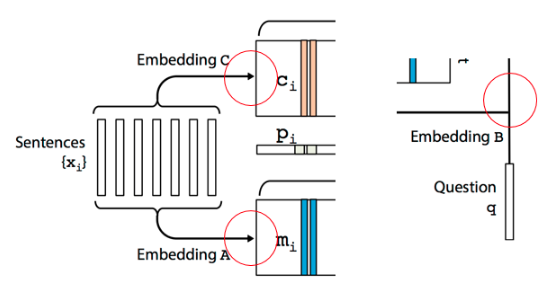

### 스토리 문장의 메모리 표현(Embeddng A) ⇒ 행렬 m
스토리 문장에 있는 단어들은 ```Embedding A```를 거쳐 각각의 임베딩 벡터로 임베딩된다. 

스토리 문장의 길이가 68, 임베딩 벡터의 차원이 50일 때, 68 길이의 스토리 문장을 ```Embedding A```에 입력해 얻는 행렬의 크기는 (68,50)이다. (배치 크기 고려하지 않을 때)

즉 Embedding A를 적용한 후의 결과는 (story_max_len, embed_size)이다. 

### 스토리의 두 번째 메모리 표현(Embedding C) ⇒ 행렬 c
```Embedding C```는 예측을 위해 필요한 입력 임베딩이다. 임베딩 벡터의 차원 = 질문 문장의 길이

따라서 스토리 문장의 길이가 68, 질문의 길이가 4라면 68의 길이를 가지는 스토리 문장의 ```Embedding C```에 입력해 얻는 텐서의 크기는 (68, 4)이다. Embedding C는 story_max_len의 길이를 가지는 스토리 문장을 입력받아서 (story_max_len, question_max_len)를 리턴한다. 

In [31]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)


### 질문 문장의 메모리 표현(Embedding B) ⇒ 행렬 u
질문 문장에 있는 단어들은 ```Embedding B```를 거치면서 임베딩 벡터로 변환된다. 

질문 문장의 길이가 4, 임베딩 벡터의 차원이 50이면, (배치 크기를 고려하지 않을 때) 4의 길이를 가지는 질문 문장을 ```Embedding B```에 입력해 얻는 행렬의 크기는 (4, 50)이다. 

즉 Embedding B는 question_max_len의 길이를 가지는 질문 문장을 입력받아서 (question_max_len, embed_size)를 리턴한다.


In [32]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [33]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 70, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'") 

Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 70, 5), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'") 

Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 5, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'") 



이제 구현해야 할 것은 스토리 문장과 질문 문장의 매칭 유사도 계산 과정이다. 

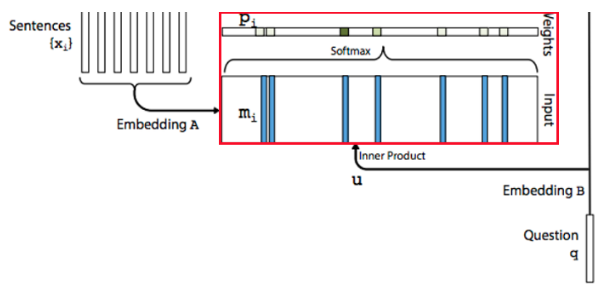

- ```m```: 스토리 문장을 ```Embedding A```에 거쳐서 얻은 결과 텐서
- ```u```: 질문 문장을 ```Embedding B```에 거쳐서 얻은 결과 텐서
- ```p```: ```m```과 ```u```의 매칭 유사도

텐서 ```m```과 ```u```의 매칭 유사도를 내적을 통해 구하고 softmax를 통과한다. 

$$p=Softmax(dot(m, u))$$

위 수식은 미분 가능한 soft attention이므로 End-to-End로 연결 가능하다. 
여기서 ```p```의 크기는 ```(max_story_len, question_max_len)```, 즉 행렬의 크기가 (68, 4)이다. 각 행렬의 원소가 의미하는 수치는 스토리에 있는 각 68개의 단어와 질문에 있는 각 4개의 단어에 대한 유사도를 의미한다. 

In [34]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 70, 5), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")


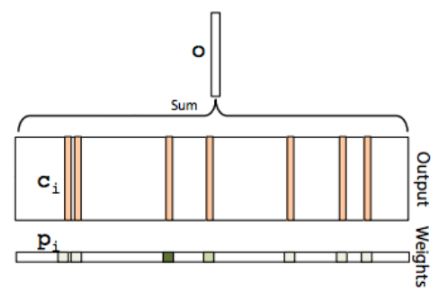

예측에 사용되는 출력 행렬은 매칭 유사도 match와 스토리 표현 input_encoded_c을 더해서 구하게 됩니다.

예측에 사용되는 출력 행렬 ```o```는 매칭 유사도 ```p```와 스토리 표현 ```c```를 더해 준다. 이 때 출력 행렬 ```o```의 크기는 (story_max_len, question_max_len), 즉 (68, 4)의 크기이다. 

$$o = add(c, p)$$

행렬 ```o``` 에는 스토리와 질문의 매칭 유사도 ```p```와 스토리 표현 ```c```이 포함되어 있다. 

In [35]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 5, 70), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")


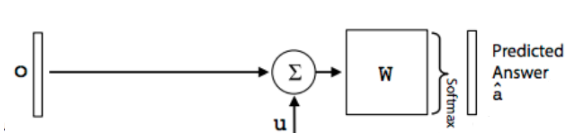

질문에 대한 임베딩은 이전에 매칭 유사도를 위해 만들었던 행렬 ```u```를 다시 사용한다. 여기서는 출력 벡터 ```o```와 질문 행렬 ```u```를 연결(concatenate)한다. 

그러나 출력 벡터 ```o```의 크기는 (68, 4)이고, 질문 행렬 ```u```의 크기는 (4, 50)이므로 서로 크기가 안 맞기 때문에 출력 벡터 ```o```의 크기를 (4, 68)로 변경한 후 두 행렬을 연결한다.

$$t = concat(o, u)$$

연결된 행렬을 ```t```라고 하면 이 행렬의 크기는 (4, 118)이다. 



메모리 네트워크는 만들어진 최종 행렬 ```t```에 LSTM을 거치게 하고, LSTM의 출력을 Dense(완전연결층)를 거치게 한 뒤에 Softmax를 통해 답안을 예측하게 한다.

$$Predicted Answer = Softmax(Dense(LSTM(t)))$$

이 연산을 $W$로 요약하면 아래의 식과 같다.

$$Predicted Answer = Softmax(W(t))$$


In [36]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 5, 120), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [37]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/e-28-korean/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 6s 7ms/step - loss: 1.9675 - acc: 0.1709 - val_loss: 1.7290 - val_acc: 0.2370
Epoch 2/120
313/313 [==============================] - 1s 4ms/step - loss: 1.6780 - acc: 0.2599 - val_loss: 1.5925 - val_acc: 0.3330
Epoch 3/120
313/313 [==============================] - 1s 4ms/step - loss: 1.5636 - acc: 0.3534 - val_loss: 1.4452 - val_acc: 0.4380
Epoch 4/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4831 - acc: 0.4121 - val_loss: 1.3813 - val_acc: 0.4830
Epoch 5/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4172 - acc: 0.4511 - val_loss: 1.3257 - val_acc: 0.4970
Epoch 6/120
313/313 [==============================] - 1s 4ms/step - loss: 1.3521 - acc: 0.4708 - val_loss: 1.3302 - val_acc: 0.5020
Epoch 7/120
313/313 [==============================] - 1s 4ms/step - loss: 1.3145 - acc: 0.4981 - val_loss: 1.2934 - val_acc: 0.4930
Epoch 8/120
313/313 [==============================] - 1s 4ms/step - 

In [38]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.1812 - acc: 0.9580

 테스트 정확도: 0.9580


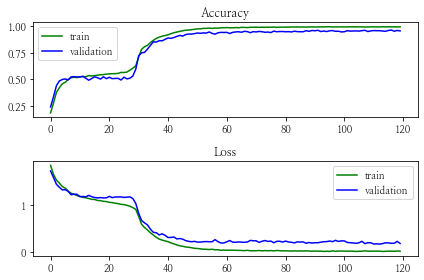

In [39]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [40]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이 는 어디 야 ?        : 복도       복도
필웅이 는 어디 야 ?        : 화장실      화장실
경임이 는 어디 야 ?        : 부엌       부엌
경임이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 부엌       부엌
경임이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 정원       정원
수종이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 사무실      사무실
수종이 는 어디 야 ?        : 사무실      사무실
필웅이 는 어디 야 ?        : 부엌       부엌
필웅이 는 어디 야 ?        : 정원       정원
수종이 는 어디 야 ?        : 사무실      사무실
필웅이 는 어디 야 ?        : 침실       침실
필웅이 는 어디 야 ?        : 침실       침실
은경이 는 어디 야 ?        : 부엌       부엌
은경이 는 어디 야 ?        : 정원       정원
은경이 는 어디 야 ?        : 부엌       부엌
수종이 는 어디 야 ?        : 사무실      사무실
은경이 는 어디 야 ?        : 부엌       복도
필웅이 는 어디 야 ?        : 복도       복도
은경이 는 어디 야 ?        : 사무실      사무실
은경이 는 어디 야 ?        : 사무실      사무실
경임이 는 어디 야 ?        : 복도       복도
수종이 는 어디 야 ?        : 침실       침실
경임이 는 어디 야 ?        : 침실       침실
필웅이 는 어디 야 ?        : 침실       침실
수종

### Step 2. 형태소 분석 후 불용어 처리하기
형태소 분석기로 문자를 분석해보면 '는', '으로' 등 분석에 크게 도움이 되지 않을 것 같은 토큰들이 나올 거에요. 처음에는 이 토큰들도 그대로 사용해서 모델을 구현해보고, 두 번째 구현에서는 이 토큰들을 전처리 과정에서 불용어 처리하여 제외해 봅시다.

In [41]:
stopwords = {'는', '으로', '야', '로'}

In [42]:
from ckonlpy.tag import Postprocessor

postprocessor = Postprocessor(
    base_tagger = twitter, # base tagger
    stopwords = stopwords, # 해당 단어 필터
)

In [43]:
print(postprocessor.pos("은경이는 화장실로 이동했습니다."))

[('은경이', 'Noun'), ('화장실', 'Noun'), ('이동', 'Noun'), ('했습니다', 'Verb'), ('.', 'Punctuation')]


In [44]:
def remove_stopwords(sent):
    sent_list = []
    sentence = postprocessor.pos(sent)
    for i in range(len(sentence)):
        sent_list.append(sentence[i][0])
    return sent_list

In [45]:
a = remove_stopwords('은경이는 화장실로 이동했습니다.')
a

['은경이', '화장실', '이동', '했습니다', '.']

In [46]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()  # FreqDist(): 문서에 사용된 단어(토큰)의 사용빈도 정보를 담는다.
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수, reduce(): 앞의 원소에서부터 누적적으로 함수에 적용
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = remove_stopwords(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = remove_stopwords(flatten(question))
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = remove_stopwords(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)  # np.max: 전체의 최대값 구하기
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [47]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [48]:
# 단어장 출력
print(word2idx)

{'.': 1, '했습니다': 2, '경임이': 3, '은경이': 4, '수종이': 5, '필웅이': 6, '이동': 7, '가버렸습니다': 8, '뛰어갔습니다': 9, '복귀': 10, '화장실': 11, '정원': 12, '복도': 13, '갔습니다': 14, '사무실': 15, '부엌': 16, '침실': 17, '어디': 18, '?': 19}


실제 변수로 사용할 단어장의 크기는 패딩을 고려해 +1을 해주어야 한다.

In [49]:
vocab_size = len(word2idx) + 1

In [50]:
print(vocab_size)

20


In [51]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 50
질문의 최대 길이 : 3


In [52]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in remove_stopwords(flatten(story))]
        xq = [word2idx[w] for w in remove_stopwords(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1) # 정답은 원-핫 인코딩

In [53]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [54]:
# 결과의 크기(shape) 확인
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 50) (10000, 3) (10000, 20) (1000, 50) (1000, 3) (1000, 20)


In [55]:
# 주요 하이퍼파라미터 정의
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 128

# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [56]:
# 입력 변수 정의

input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


이제 본격적으로 메모리 네트워크 모델을 구현한다. 



In [57]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [58]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [59]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 50, 50), dtype=tf.float32, name=None), name='sequential_3/dropout_4/Identity:0', description="created by layer 'sequential_3'") 

Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 50, 3), dtype=tf.float32, name=None), name='sequential_4/dropout_5/Identity:0', description="created by layer 'sequential_4'") 

Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 3, 50), dtype=tf.float32, name=None), name='sequential_5/dropout_6/Identity:0', description="created by layer 'sequential_5'") 



In [60]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 50, 3), dtype=tf.float32, name=None), name='activation_2/truediv:0', description="created by layer 'activation_2'")


In [61]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 3, 50), dtype=tf.float32, name=None), name='permute_1/transpose:0', description="created by layer 'permute_1'")


In [62]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 3, 100), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


In [63]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/e-28-korean/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 4s 5ms/step - loss: 1.9692 - acc: 0.1636 - val_loss: 1.7950 - val_acc: 0.2110
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.7692 - acc: 0.2139 - val_loss: 1.5890 - val_acc: 0.4050
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5760 - acc: 0.3664 - val_loss: 1.5236 - val_acc: 0.3940
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5145 - acc: 0.3948 - val_loss: 1.4831 - val_acc: 0.4130
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4822 - acc: 0.4097 - val_loss: 1.4464 - val_acc: 0.4350
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4092 - acc: 0.4502 - val_loss: 1.3948 - val_acc: 0.4730
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.3936 - acc: 0.4567 - val_loss: 1.3823 - val_acc: 0.4570
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

In [64]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.1402 - acc: 0.9650

 테스트 정확도: 0.9650


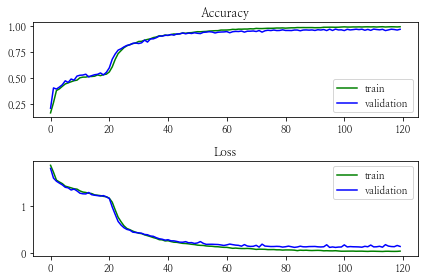

In [65]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [66]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이 어디 ?            : 복도       복도
필웅이 어디 ?            : 화장실      화장실
경임이 어디 ?            : 부엌       부엌
경임이 어디 ?            : 복도       복도
경임이 어디 ?            : 부엌       부엌
경임이 어디 ?            : 복도       복도
경임이 어디 ?            : 정원       정원
수종이 어디 ?            : 복도       복도
경임이 어디 ?            : 사무실      화장실
수종이 어디 ?            : 사무실      사무실
필웅이 어디 ?            : 부엌       부엌
필웅이 어디 ?            : 정원       정원
수종이 어디 ?            : 사무실      사무실
필웅이 어디 ?            : 침실       침실
필웅이 어디 ?            : 침실       침실
은경이 어디 ?            : 부엌       부엌
은경이 어디 ?            : 정원       정원
은경이 어디 ?            : 부엌       부엌
수종이 어디 ?            : 사무실      사무실
은경이 어디 ?            : 부엌       부엌
필웅이 어디 ?            : 복도       복도
은경이 어디 ?            : 사무실      사무실
은경이 어디 ?            : 사무실      사무실
경임이 어디 ?            : 복도       복도
수종이 어디 ?            : 침실       침실
경임이 어디 ?            : 침실       침실
필웅이 어디 ?            : 침실       침실
수종

### Step 3. 한국어에서의 모델 정확도 확인해보기
앞서 만든 메모리 네트워크는 영어권 데이터에서는 보편적으로 약 96% 이상의 높은 성능을 보입니다. 하이퍼파라미터를 잘 조정하면 이보다 더 높은 정확도가 나오기도 합니다. 그렇다면 메모리 네트워크가 한국어에서도 영어만큼 잘 동작할까요? 직접 확인해 봅시다.

- 결과 정리

노드에서 수행한 영어 데이터에서는 약 96%의 정확도를 보였다. 같은 하이퍼파라미터를 사용했을 경우, 한국어 데이터의 정확도가 영어 데이터의 정확도보다 조금 낮게 나왔다. 몇 번의 실험 끝에 하이퍼파라미터를 조정하였더니 토큰화를 한 한국어 데이터에서는 95.80%가 나왔고, 불용어를 처리한 후의 정확도는 96.20%이 나왔다. 따라서 한국어 데이터라도 전처리를 제대로 하고, 하이퍼파라미터를 잘 조정하면 영어 데이터와 비슷한 수준의 정확도가 나올 것으로 예상한다.  

## 루브릭

|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. 한국어의 특성에 알맞게 전처리가 진행되었다.|한국어 특성에 따른 토큰화, 임베딩을 거쳐 데이터셋이 적절히 구성되었다.|Y     |
|2. 메모리 네트워크가 정상적으로 구현되어 학습이 안정적으로 진행되었다.|validation loss가 안정적으로 수렴하는 것을 확인하고 이를 시각화하였다.|Y|
|3. 메모리 네트워크를 통해 한국어 bAbI 태스크의 높은 정확도를 달성하였다.|추론 태스크의 테스트 정확도가 90% 이상 달성하였다.| Y    |

## 후기
### 이번 프로젝트에서 어려웠던 점
- 불용어 처리 부분이 조금 까다로웠다. 불용어 처리와 토큰화를 같이 해야 하는 것인지 고민해야 했다. 불용어 처리를 하면 토큰화를 한 것과 같은 결과가 나왔고, 불용어 처리를 하고, 토큰화를 하면 토큰이 더 작게 나오기 때문에 좋은 결과가 나오지 않을 것 같아 불용어 처리만 해 주었다.

### 프로젝트를 진행하면서 알게된 점
- End-to-End Memory Network
- bAbl task
- 새로운 토큰화 패키지를 알게 되었다.

### 자기 다짐
이번 프로젝트는 예상보다 어렵지는 않았다. 노드에서도 코드 설명이 자세했고, 코드도 직관적이라 설명을 보면서 이해할 수 있었다. 

End-to-End Memory Network의 개념이 매력적이다. 앞으로 더 발전해서 대화가 통하는 챗봇이 나왔으면 한다. 